# After EDA , Applying Various Machine Learning Algorithms

### No feature engineering
### Applying Min-Max normalization

*For all the models*

In This notebook, I've tried
* Logistic Regression
* Decision trees(basic and normalized)
* Random forest(basic and normalized)
* Light Gradient boosting machine(basic and normalized)
* Multi layered perceptron

Out of all **Light Gradient boosting machine** performed Phenomenal on Kaggle Data, and put me on top 10% at Kaggle Leaderboard


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
import lightgbm as lgbm
import joblib
import os
import seaborn as sns
import matplotlib.pyplot as plt
import neurokit2 as nk
from biosppy.signals import  ecg
import matplotlib as mpl
mpl.rcParams['agg.path.chunksize'] = 10000
import warnings
warnings.filterwarnings("ignore")

In [3]:
raw = pd.read_csv("train.csv")

In [3]:
Y = raw['event']
raw_del = raw.drop(['crew', 'experiment', 'seat', 'event'], axis=1 )
X = raw_del
print(f"X.shape:{X.shape}")
print(f"Y.shape:{Y.shape}")


X.shape:(4867421, 24)
Y.shape:(4867421,)


In [ ]:
X.head(2)

In [5]:
Y.head(2)

0    A
1    A
Name: event, dtype: object

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, stratify=Y, test_size=.2)
print(f"X_train.shape:{X_train.shape}")
print(f"y_train.shape:{y_train.shape}")
print(f"X_test.shape:{X_test.shape}")
print(f"y_test.shape:{y_test.shape}")

X_train.shape:(3893936, 24)
y_train.shape:(3893936,)
X_test.shape:(973485, 24)
y_test.shape:(973485,)


In [ ]:
features = X_train.columns

In [ ]:
scaler = MinMaxScaler()
scaler.fit(X_train)

X_train_norm = scaler.transform(X_train)
X_test_norm = scaler.transform(X_test)

### Before getting started with Training Let's get the Results from RANDOM model, comparison between RANDOM and trained model will get better understanding on whether the training is really causing any impact or not.

In [34]:
d = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
y_train_ = np.array(list(map(lambda x: d[x], y_train)))
y_test_ =  np.array(list(map(lambda x: d[x], y_test)))

In [39]:
train_len = X_train.shape[0]
test_len = X_test.shape[0]
 
train_predicted_y = np.zeros((train_len,4))
for i in range(train_len):
    rand_probs = np.random.rand(1,4)
    train_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on TRAIN Data using Random Model",log_loss(y_train,train_predicted_y, eps=1e-15))

 
test_predicted_y = np.zeros((test_len,4))
for i in range(test_len):
    rand_probs = np.random.rand(1,4)
    test_predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on TEST Data using Random Model",log_loss(y_test,test_predicted_y, eps=1e-15))


Log loss on TRAIN Data using Random Model 1.6444425154133833
Log loss on TEST Data using Random Model 1.64606303273689


### Train Confusion matrix on RANDOM MODEL

Normalized confusion matrix
[[0.58611374 0.026852   0.33888336 0.0481509 ]
 [0.58511872 0.02673072 0.33964394 0.04850662]
 [0.58437483 0.0269621  0.34042396 0.04823911]
 [0.58551838 0.02677882 0.33920833 0.04849446]]


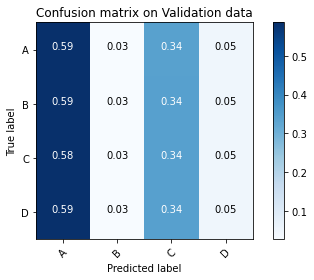

In [35]:
conf_mat_val = confusion_matrix(np.argmax(train_predicted_y, axis=1), y_train_)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

### Test Confusion matrix on RANDOM MODEL

Normalized confusion matrix
[[0.58418243 0.02681675 0.34091124 0.04808959]
 [0.58467298 0.02649058 0.340256   0.04858044]
 [0.58531266 0.02705411 0.33978848 0.04784475]
 [0.58696127 0.02696077 0.33719919 0.04887876]]


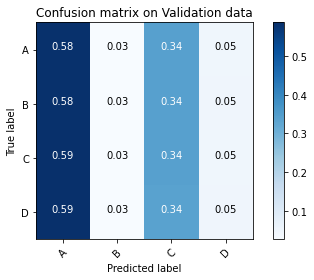

In [36]:
conf_mat_val = confusion_matrix(np.argmax(test_predicted_y, axis=1), y_test_)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

Log loss on TRAIN Data using Random Model **1.6444425154133833** 

Log loss on TEST Data using Random Model **1.64606303273689**

# Logistic Regression

In [ ]:

LoR_rs = LogisticRegression()
params = {"C":[0.01, 0.001, 1, 0.1, 10]}
    
rs = RandomizedSearchCV(LoR_rs, params, cv=3, return_train_score=True, n_jobs=-1)
rs.fit(X_train_norm, y_train)


In [12]:
rs.best_params_

{'C': 10}

In [7]:
LoR = LogisticRegression(C=10)
LoR.fit(X_train_norm, y_train)

LogisticRegression(C=10)

In [8]:
LoR.classes_

array(['A', 'B', 'C', 'D'], dtype=object)

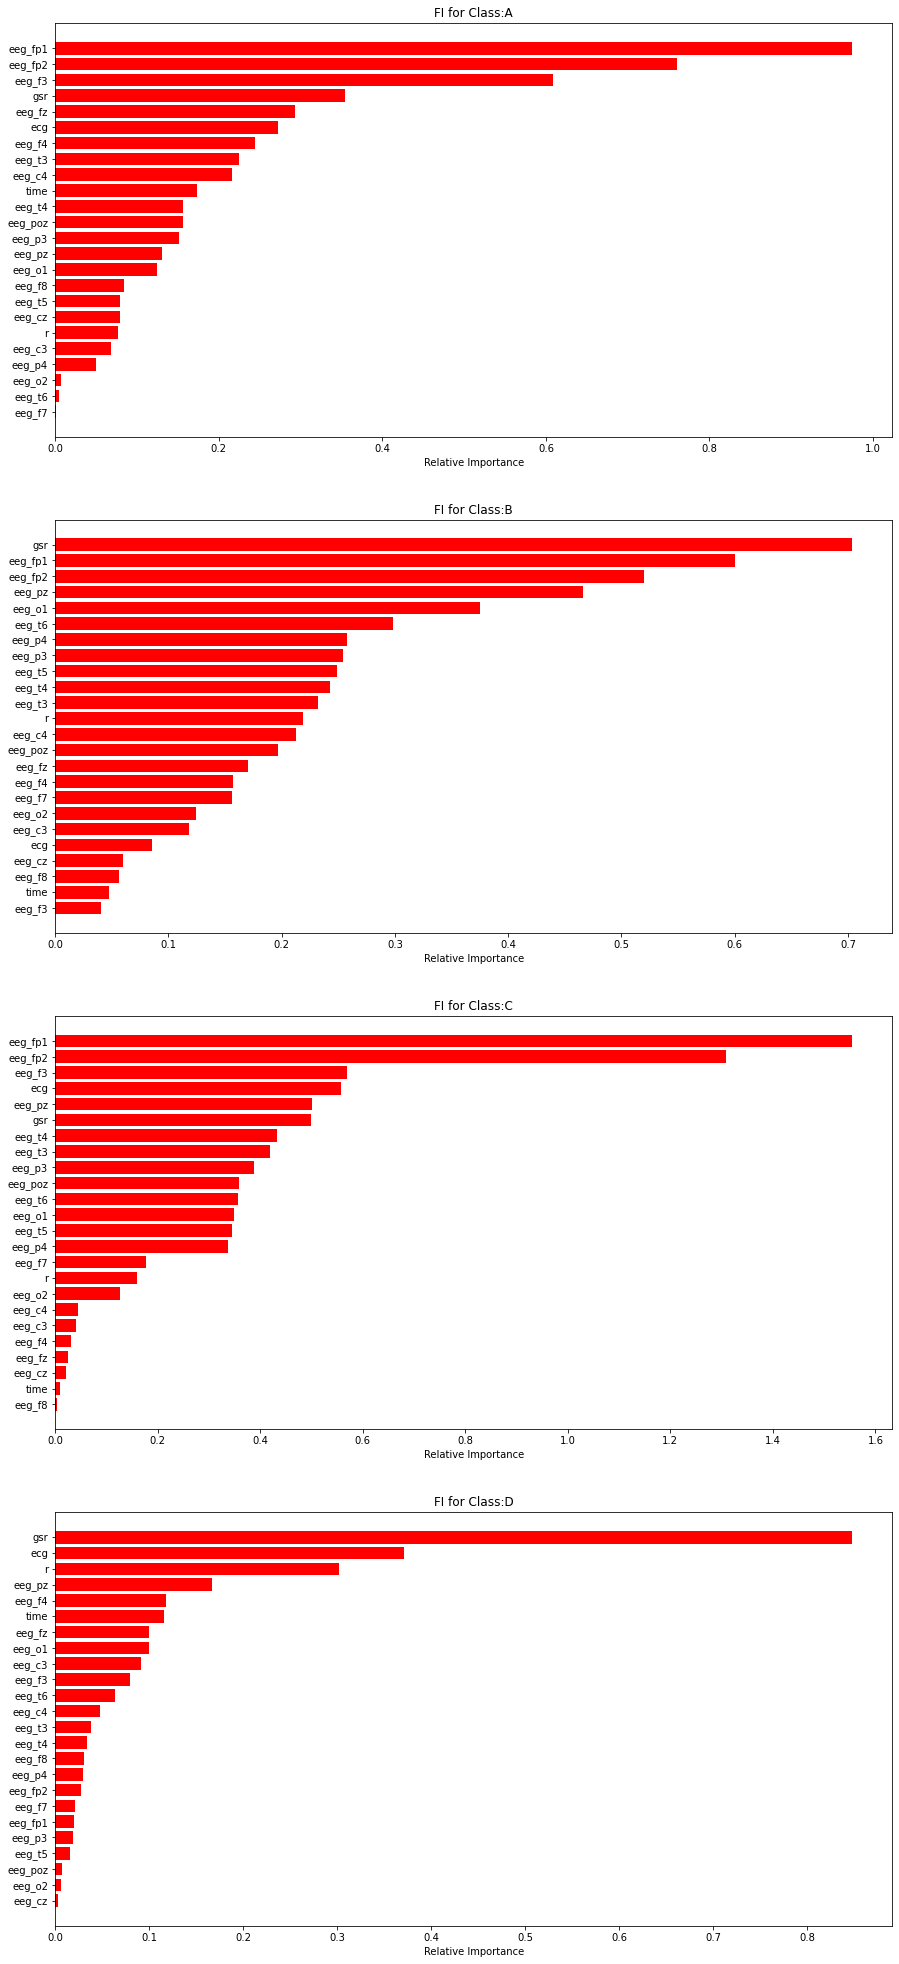

In [9]:
lor_cls = LoR.classes_
plt.figure(figsize=(15,35))
for i in range(len(lor_cls)):
    
    importances = np.array(list(map(lambda x: abs(x), LoR.coef_[i])))
    indices = (np.argsort(importances))
    ax = plt.subplot(4,1,i+1)
    ax.set_title('Feature Importances')
    ax.title.set_text(f"FI for Class:{LoR.classes_[i]}")
    ax.set_xlabel('Relative Importance')
    
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.barh(range(len(indices)), importances[indices], color='r', align='center')
 
   

In [83]:
d = {
    0:'A',
    1:'B',
    2:'C',
    3:'D'
    }
d_ = {
    'A':0,
    'B':1,
    'C':2,
    'D':3
    }
    
    

In [10]:
y_train_pred = LoR.predict_proba(X_train_norm)
y_test_pred = LoR.predict_proba(X_test_norm)

In [91]:
y_tr_pred =  np.argmax((y_train_pred), axis=-1)
y_te_pred =  np.argmax((y_test_pred), axis=-1)

In [11]:
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:0.9152154639270628
Test log_loss:0.9152124679601766


In [96]:
import joblib
joblib.dump(LoR,'Logistic_Regression_no_fe.pkl')

['Logistic_Regression_no_fe.pkl']

### Clearly can see Logistic Regression performed Badly on the dataset

# Random Forest

### Random Search

In [9]:
RF_rs = RandomForestClassifier()

params = {"n_estimators":[5, 10, 20],
"max_depth" : [100, 200],}
    
rs = RandomizedSearchCV(RF_rs, params, cv=2, return_train_score=True, n_jobs=-1, verbose=200)
rs.fit(X_train_norm, y_train)


Fitting 2 folds for each of 6 candidates, totalling 12 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [100, 200],
                                        'n_estimators': [5, 10, 20]},
                   return_train_score=True, verbose=200)

In [11]:
rs.best_params_

{'n_estimators': 20, 'max_depth': 200}

### Best Parameters
### {'n_estimators': 20, 'max_depth': 200}

In [12]:
RF = RandomForestClassifier(n_estimators = 20, max_depth = 200)
RF.fit(X_train_norm, y_train)

RandomForestClassifier(max_depth=200, n_estimators=20)

### Feature Importance

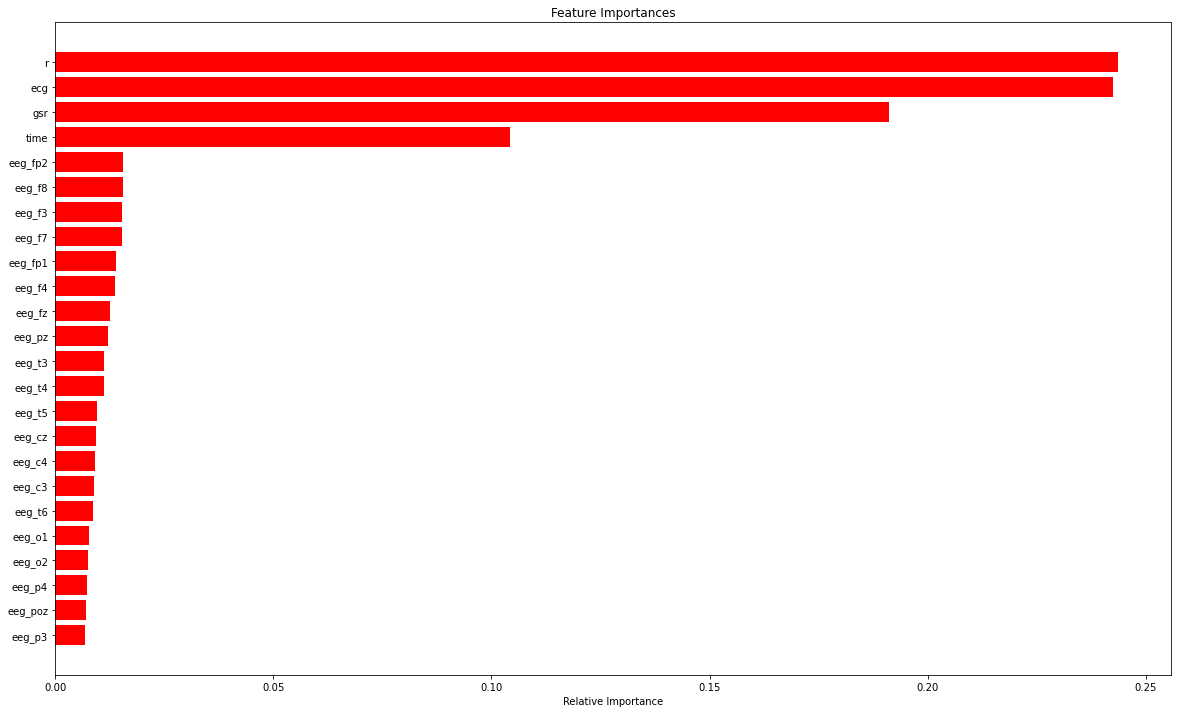

In [15]:
importances = RF.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
   

In [16]:
y_train_pred = RF.predict_proba(X_train_norm)
y_test_pred = RF.predict_proba(X_test_norm)

In [17]:
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:0.02411434956523283
Test log_loss:0.07210270077912996


### Log Loss is better now

In [18]:
# import joblib
# joblib.dump(RF,'Random_forest_no_fe.pkl')
# X_train_norm = joblib.load("X_train_norm")
# X_test_norm = joblib.load("X_test_norm")
# y_train = joblib.load("y_train")
# y_test = joblib.load("y_Test")
# RF = joblib.load('Random_forest_no_fe.pkl')

['Random_forest_no_fe.pkl']

# Decision Tree

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV 
params = {"max_depth" : [200,300], 
              "min_samples_split": [10, 50, 100],
          "min_samples_leaf": [10, 20, 50]
              } 
DT_rs = DecisionTreeClassifier()
rs = RandomizedSearchCV(DT_rs,params,cv=2,verbose=200, n_jobs=-1)
rs.fit(X_train_norm, y_train)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=DecisionTreeClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [200, 300],
                                        'min_samples_leaf': [10, 20, 50],
                                        'min_samples_split': [10, 50, 100]},
                   verbose=200)

In [1]:
DT_rs.best_params_ 

{'n_estimators': 200, 'min_samples_split': 50, 'min_samples_leaf': 50}

In [ ]:
DT = DecisionTreeClassifier(max_depth= 200, min_samples_split= 50, min_samples_leaf= 50, random_state=40)
DT.fit(X_train_norm, y_train)

In [2]:
# joblib.dump(DT, "Decision_tree_no_fe.pkl")
# DT = joblib.load("Decision_tree_no_fe.pkl")

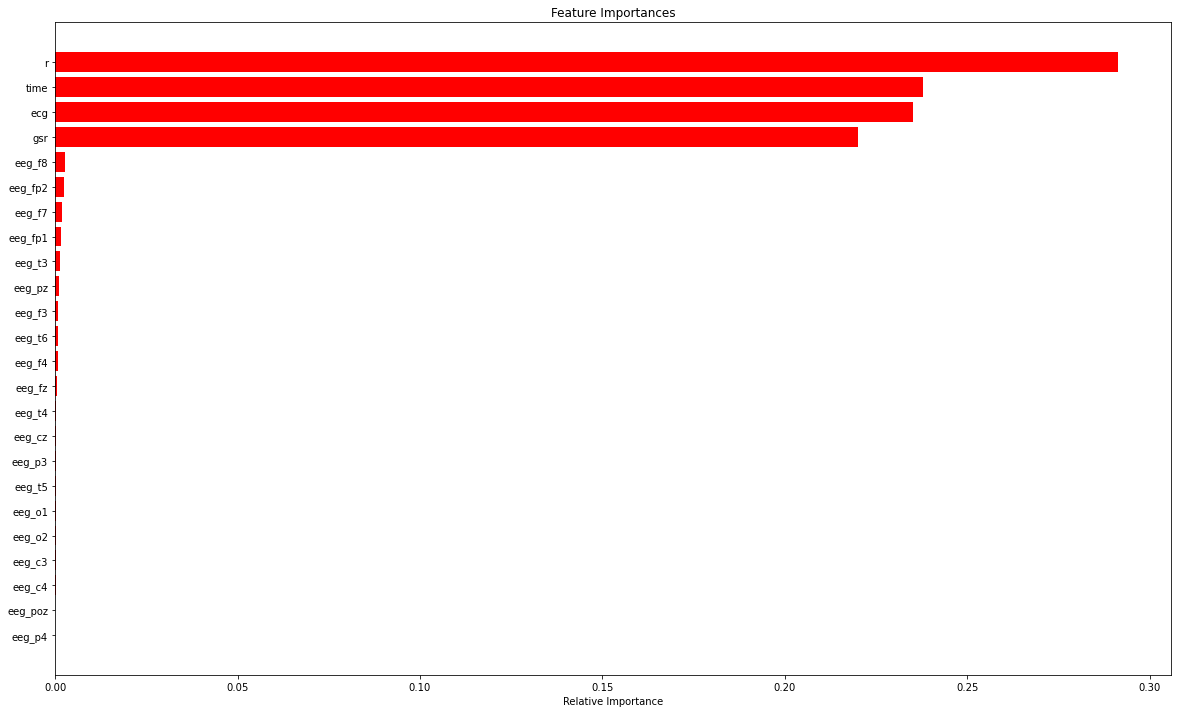

In [13]:
importances = DT.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [3]:
# X_train_norm = joblib.load("X_train_norm")
# X_test_norm = joblib.load("X_test_norm")
# y_train = joblib.load("y_train")
# y_test = joblib.load("y_Test")
# # joblib.dump(scaler, "scaler")

In [4]:
y_train_pred = DT.predict_proba(X_train_norm)
y_test_pred = DT.predict_proba(X_test_norm)

In [5]:
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:0.010608129320006533
Test log_loss:0.011524040127252399


### Log Loss is better than Random Forest, But on unseen Kaggle test Data it performed really poor

![title](DT_score.png)

# Light GBM

#### Random Search for hyperparameters

In [17]:

params = {"max_depth" : [20, 50, 100], 
              "num_leaves": [20, 50, 70],
          "n_estimators": [30, 50, 70]
              } 
LGBM_rs = lgbm.LGBMClassifier()
rs = RandomizedSearchCV(LGBM_rs, params, cv=2, verbose=200, n_jobs=-1)
rs.fit(X_train_norm, y_train)


Fitting 2 folds for each of 10 candidates, totalling 20 fits


RandomizedSearchCV(cv=2, estimator=LGBMClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': [20, 50, 100],
                                        'n_estimators': [30, 50, 70],
                                        'num_leaves': [20, 50, 70]},
                   verbose=200)

In [21]:
print("Tuned Decision Tree Parameters: {}".format(rs.best_params_)) 
print("Best score is {}".format(rs.best_score_)) 

Tuned Decision Tree Parameters: {'num_leaves': 70, 'n_estimators': 70, 'max_depth': 100}
Best score is 0.9912766927859112


### Tuned Decision Tree Parameters: {'num_leaves': 70, 'n_estimators': 70, 'max_depth': 100}
### Best score is 0.9912766927859112

In [22]:
LGBM = lgbm.LGBMClassifier(num_leaves = 70, n_estimators = 70, max_depth = 100)
LGBM.fit(X_train_norm, y_train)

LGBMClassifier(max_depth=100, n_estimators=70, num_leaves=70)

In [ ]:
features = ['crew', 'eeg_fp1', 'eeg_f7', 'eeg_f8',
       'eeg_t6', 'eeg_t3', 'eeg_fp2', 'eeg_o1','eeg_c3',
       'eeg_pz', 'eeg_f3', 'eeg_fz', 'eeg_ f4', 'eeg_c4', 'eeg_poz',
       'eeg_cz', 'eeg_o2', 'ecg', 'r', 'gsr','pilot']

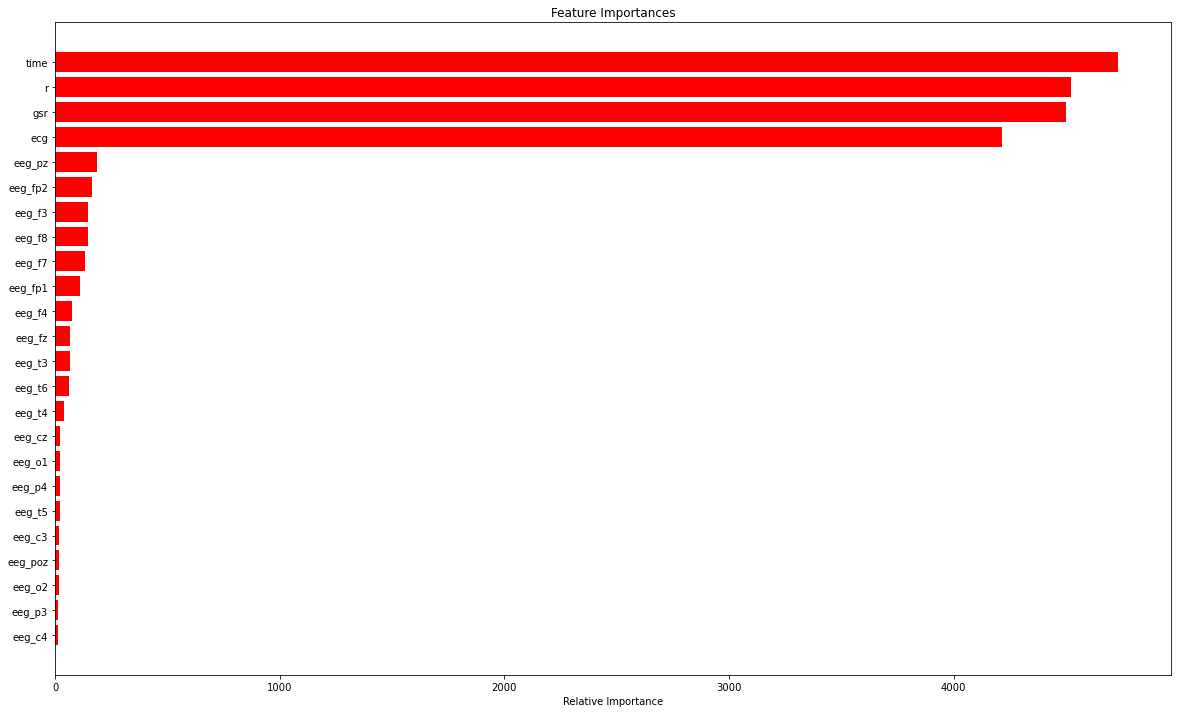

In [23]:
importances = LGBM.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [28]:
y_train_pred = LGBM.predict_proba(X_train_norm)
y_test_pred = LGBM.predict_proba(X_test_norm)

In [29]:
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:0.04256896540791801
Test log_loss:0.04247729919623576


#### Log Loss is good, But on Kaggle test data it's not very great!

![title](LGBM_no_fe_score.png)

In [30]:
import joblib
joblib.dump(LGBM,'light_no_fe.pkl')

['light_no_fe.pkl']

In [9]:
# joblib.dump(X_train_norm, "X_train_norm")
# joblib.dump(X_test_norm, "X_test_norm")
# joblib.dump(y_train, "y_train")
# joblib.dump(y_test, "y_Test")
# joblib.dump(scaler, "scaler")

# X_train_norm = joblib.load("X_train_norm")
# X_test_norm = joblib.load("X_test_norm")
# y_train = joblib.load("y_train")
# y_test = joblib.load("y_Test")

# LGBM = joblib.load('light_no_fe.pkl')


# Applying models on Unseen Data

### Decision Tree

In [2]:
scaler = joblib.load("scaler")

In [3]:
DT = joblib.load("Decision_tree_no_fe.pkl")

In [4]:
test_df = pd.read_csv("test.csv")

In [5]:
test_df.head()

,id,crew,experiment,time,seat,eeg_fp1,eeg_f7,eeg_f8,eeg_t4,eeg_t6,...,eeg_f4,eeg_c4,eeg_p4,eeg_poz,eeg_c3,eeg_cz,eeg_o2,ecg,r,gsr
0,0,1,LOFT,0.000000,0,17.899500,6.127830,0.994807,-28.206200,-47.695499,...,-7.044480,-14.405100,-4.03384,-0.393799,31.83810,17.075600,-8.137350,-7323.120117,643.177002,594.778992
1,1,1,LOFT,0.000000,1,45.883202,94.749001,23.290800,1.392000,2.060940,...,19.887501,-215.179001,2.11832,7.340940,9.66785,1169.239990,-0.024414,-3335.080078,826.724976,136.235001
2,2,1,LOFT,0.003906,0,33.120098,28.356501,-7.239220,-7.690860,-25.833799,...,-7.642560,-10.363600,10.95050,6.513360,36.01860,24.356600,0.956158,-7323.120117,643.177002,594.778992
3,3,1,LOFT,0.003906,1,43.280102,95.887001,18.702299,-1.432890,-4.232600,...,13.826600,-214.223007,-4.91354,3.504520,3.87811,1159.400024,-0.047607,-3335.080078,826.724976,136.235001
4,4,1,LOFT,0.007812,0,7.929110,3.460380,-10.860800,-26.366699,-25.894699,...,2.045450,-20.788799,-3.61418,-7.539830,3.08397,13.647900,1.473720,-7323.120117,643.177002,594.778992


In [6]:
test_df_ = test_df.drop(['crew', 'experiment', 'seat', 'id'], axis=1 )

In [7]:
test_norm = scaler.transform(test_df_)

In [10]:
joblib.dump(test_norm, "test_norm")

['test_norm']

In [11]:
test_pred = DT.predict_proba(test_norm)

In [13]:
sub = pd.DataFrame(np.concatenate((np.arange(len(test_norm))[:, np.newaxis], test_pred), axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
sub['id'] = sub['id'].astype(int)

In [14]:
sub.head()

,id,A,B,C,D
0,0,1.0,0.0,0.0,0.0
1,1,0.6,0.0,0.4,0.0
2,2,1.0,0.0,0.0,0.0
3,3,0.6,0.0,0.4,0.0
4,4,1.0,0.0,0.0,0.0


In [15]:
sub.to_csv('result_no_fe.csv', index=False)

# LGBM

In [10]:
LGBM = joblib.load("light_no_fe.pkl")

In [7]:
test_norm = joblib.load("test_norm")

In [11]:
test_pred = LGBM.predict_proba(test_norm)

In [12]:
sub = pd.DataFrame(np.concatenate((np.arange(len(test_norm))[:, np.newaxis], test_pred), axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
sub['id'] = sub['id'].astype(int)

In [13]:
sub.head()

,id,A,B,C,D
0,0,0.998665,0.000012,0.001302,0.000022
1,1,0.998786,0.000011,0.001170,0.000033
2,2,0.999177,0.000008,0.000800,0.000015
3,3,0.998787,0.000011,0.001170,0.000033
4,4,0.998191,0.000015,0.001767,0.000027


In [14]:
sub.to_csv('result_lgbm_no_fe.csv', index=False)

# Most basic model

#### Let's check how will LGBM perform on Completely Raw data not even Normalized

In [4]:
Y = raw['event']
X = raw.drop('event',axis=1)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.2, shuffle=False)
print(f"X_train.shape:{X_train.shape}")
print(f"y_train.shape:{y_train.shape}")
print(f"X_test.shape:{X_test.shape}")
print(f"y_test.shape:{y_test.shape}")

X_train.shape:(3893936, 27)
y_train.shape:(3893936,)
X_test.shape:(973485, 27)
y_test.shape:(973485,)


In [6]:
d = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
y_train_ = np.array(list(map(lambda x: d[x], y_train)))
y_test_ =  np.array(list(map(lambda x: d[x], y_test)))

In [10]:
X_train['experiment'] = X_train['experiment'].astype('category')
X_test['experiment'] = X_test['experiment'].astype('category')

In [39]:
train = lgbm.Dataset(X_train, label = y_train_, categorical_feature=[1])
test = lgbm.Dataset(X_test, label = y_test_, categorical_feature=[1])
 



# Declaring the hyperparameter values. 
params = {
      "objective" : "multiclass", # used for multiclass softmax classifier
      "metric" : "multi_error",   # Error rate for multiclass classification 
      "boosting" :'gbdt',         # Using Gardient Boosted Decision Trees
      'num_class':4,              # Number of desired output classes is 4 
      "num_leaves" : 30,          # Number of leaves in Tree based algorithms
      "learning_rate" : 0.01,     
      "bagging_fraction" : 0.9,   # This is randomly select 90% of data without resampling\
                   # it will decrease impact of high variance on data
      "bagging_seed" : 0,         # Random seeds for bagging
      "num_threads" : 4,
      "colsample_bytree" : 0.5,   # Subsampling fraction for feature
      'min_data_in_leaf':100,     # Threshold on Data in a leaf
      'min_split_gain':0.00019    # Minmimum gain threshold for splitting the node
        }




# Training Stage:
print('<start>Training')
model = lgbm.train(  params, 
                  train_set = train,
                  num_boost_round=1000,
                  early_stopping_rounds=200,
                  verbose_eval=200, 
                  valid_sets=[train,test]
                )
print('<complete>Training')

<start>Training
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.267049 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6135
[LightGBM] [Info] Number of data points in the train set: 3893936, number of used features: 27
[LightGBM] [Info] Start training from score -0.570771
[LightGBM] [Info] Start training from score -3.663356
[LightGBM] [Info] Start training from score -1.013233
[LightGBM] [Info] Start training from score -3.074330
Training until validation scores don't improve for 200 rounds
[200]	training's multi_error: 0.0394583	valid_1's multi_error: 0.0692286
[400]	training's multi_error: 0.0259958	valid_1's multi_error: 0.0722374
Early stopping, best iteration is:
[235]	training's multi_error: 0.036394	valid_1's multi_error: 0.0649039
<complete>Training


In [40]:
# joblib.dump(model, "model_simple")
# model = joblib.load("model_simple")

['model_simple']

In [41]:
# y_train_pred = model.predict(X_train)
# y_test_pred = model.predict(X_test)

In [16]:

print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:0.13599888140534533
Test log_loss:0.372470041693679


In [31]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

## Confusion matrix on Train

Normalized confusion matrix
[[9.42652915e-01 1.08281561e-03 1.72012012e-06 5.62625488e-02]
 [2.21197601e-02 9.77880240e-01 0.00000000e+00 0.00000000e+00]
 [1.33163882e-03 0.00000000e+00 9.98668361e-01 0.00000000e+00]
 [7.99902656e-02 0.00000000e+00 0.00000000e+00 9.20009734e-01]]


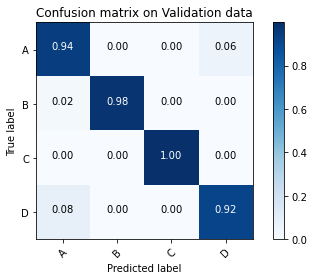

In [46]:
conf_mat_val = confusion_matrix(np.argmax(y_train_pred, axis=1), y_train_)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

## Confusion matrix on Test dataset

Normalized confusion matrix
[[9.26129580e-01 6.21153111e-03 0.00000000e+00 6.76588889e-02]
 [1.34489693e-02 9.86551031e-01 0.00000000e+00 0.00000000e+00]
 [1.37454664e-02 1.18097722e-02 9.74033172e-01 4.11589714e-04]
 [3.91706380e-01 0.00000000e+00 0.00000000e+00 6.08293620e-01]]


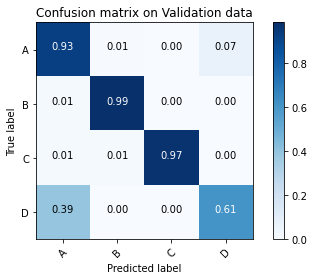

In [45]:
conf_mat_val = confusion_matrix(np.argmax(y_test_pred, axis=1), y_test_)
plot_confusion_matrix(conf_mat_val, ["A", "B", "C", "D"], title='Confusion matrix on Validation data', normalize=True)

#### So much confusion in predicting Class 'D', apart from that everything is quite good

Lets Check on Kaggle Data

In [21]:
test_df = pd.read_csv("test.csv")
test_df_ = test_df.drop([ 'id'], axis=1 )
test_df_['experiment'] = test_df_['experiment'].astype('category')

In [26]:
y_pred_simple = model.predict(test_df_)

In [28]:
sub = pd.DataFrame(np.concatenate((np.arange(len(test_df_))[:, np.newaxis], y_pred_simple), axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
sub['id'] = sub['id'].astype(int)

In [29]:
sub.to_csv('result_lgbm_simple.csv', index=False)

# RESULTS on KAGGLE test DATA

![title](LGBM_simple.png)

# Astonishing results with this simple Training dataset no feature engineering

# Lets check on DECISION TREES without altering train data at all!

In [7]:
from sklearn.preprocessing import OrdinalEncoder
exp_train = np.expand_dims(X_train['experiment'].values, axis=1)
exp_test = np.expand_dims(X_test['experiment'].values, axis=1)
enc = OrdinalEncoder()
enc.fit(exp_train)
print(enc.categories_)
X_train['experiment'] = enc.fit_transform(exp_train)
X_test['experiment'] = enc.fit_transform(exp_test)

[array(['CA', 'DA', 'SS'], dtype=object)]


In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV 

DT = DecisionTreeClassifier(max_depth = 200, min_samples_split= 50, min_samples_leaf= 50, random_state=40)
DT.fit(X_train, y_train)




DecisionTreeClassifier(max_depth=200, min_samples_leaf=50, min_samples_split=50,
                       random_state=40)

In [12]:
features = X_train.columns

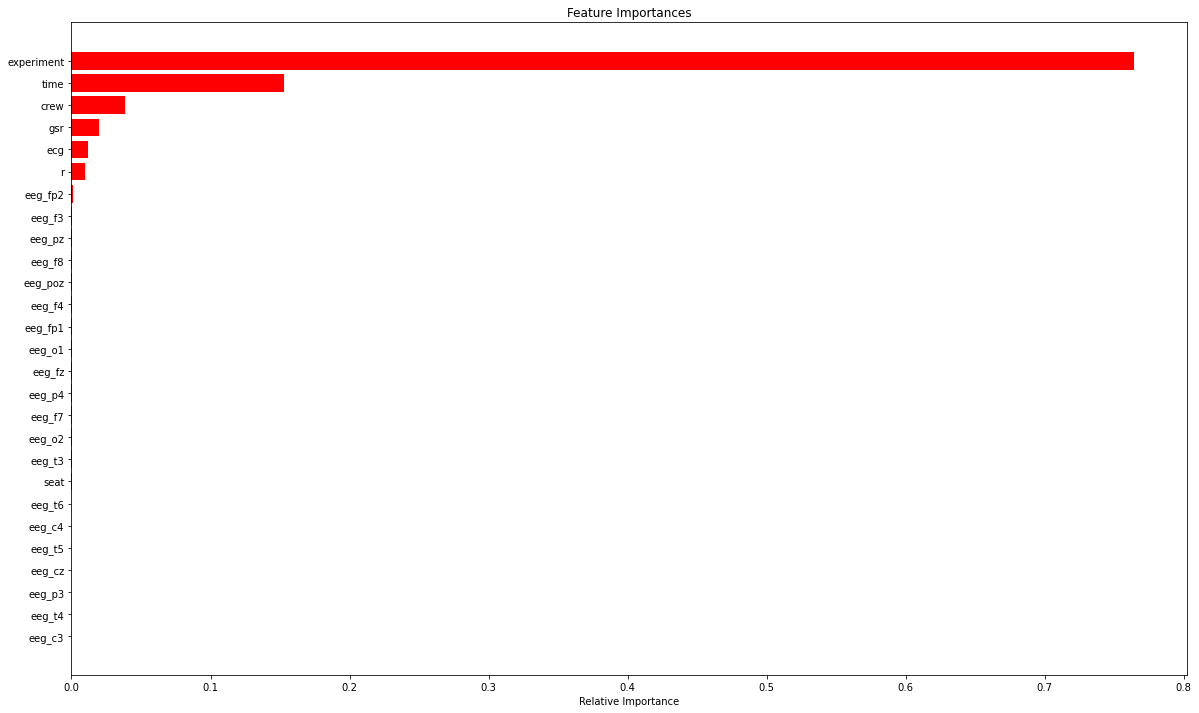

In [13]:
importances = DT.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [15]:
y_train_pred = DT.predict_proba(X_train)
y_test_pred = DT.predict_proba(X_test)
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:0.0012031847185385318
Test log_loss:3.1586377305730764


### Clearly its Overfitting, no use of testing it on Kaggle dataset !!!

# Trying out RANDOM FOREST without altering trian data at all

In [17]:
RF = RandomForestClassifier(n_estimators = 20, max_depth = 200)
RF.fit(X_train, y_train)

RandomForestClassifier(max_depth=200, n_estimators=20)

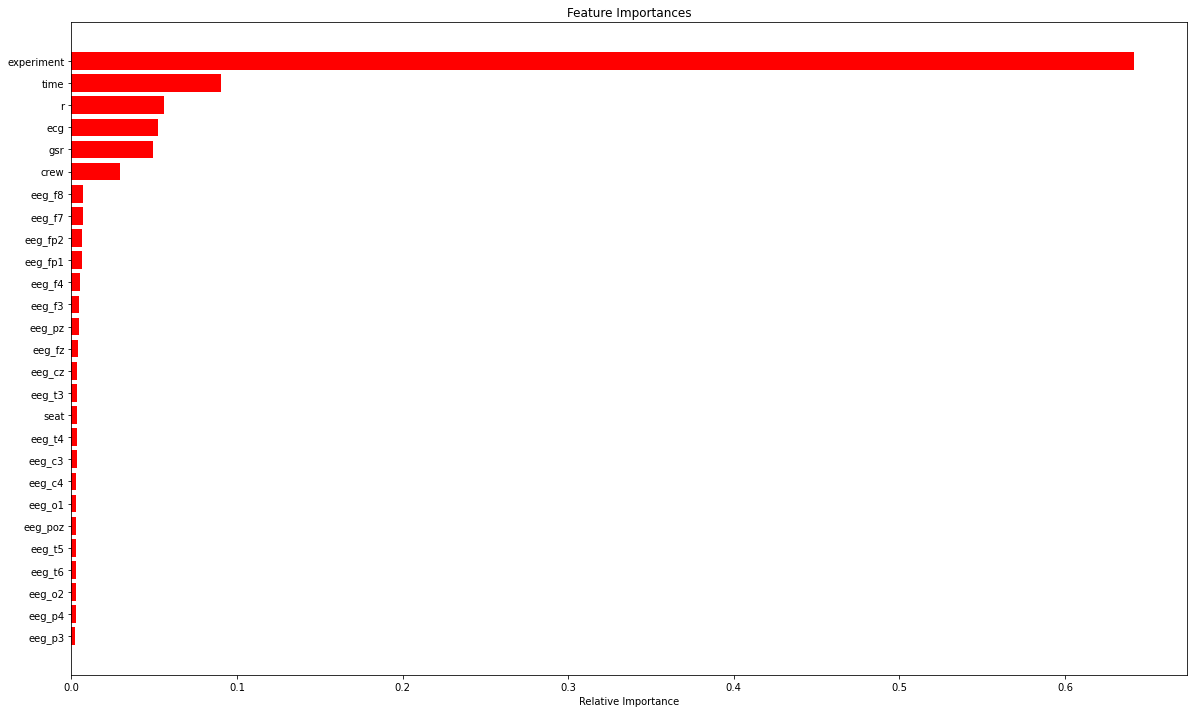

In [18]:
importances = RF.feature_importances_
indices = (np.argsort(importances))[:]
plt.figure(figsize=(20,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [20]:
y_train_pred = RF.predict_proba(X_train)
y_test_pred = RF.predict_proba(X_test)

In [21]:
print(f"Train log_loss:{log_loss(y_train, y_train_pred)}")
print(f"Test log_loss:{log_loss(y_test, y_test_pred)}")

Train log_loss:0.009149798548948868
Test log_loss:0.8016858169944082


### Its also overfitting but not as much as decision trees, Lets try on kaggle data!

In [24]:
test_df = pd.read_csv("test.csv")
test_df_ = test_df.drop([ 'id'], axis=1 )
exp_test = np.expand_dims(test_df_['experiment'].values, axis=1)
enc = OrdinalEncoder()
enc.fit(exp_test)
print(enc.categories_)
test_df_['experiment'] = enc.fit_transform(exp_test)



[array(['LOFT'], dtype=object)]


In [29]:
y_pred_simple = RF.predict_proba(test_df_)

In [30]:
sub = pd.DataFrame(np.concatenate((np.arange(len(test_df_))[:, np.newaxis], y_pred_simple), axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
sub['id'] = sub['id'].astype(int)

In [31]:
sub.to_csv('result_RF_simple.csv', index=False)

![title](RF_simple.png)

#### Extremely poor perfomance on Kaggle dataset!

## Its time for a Neural Network!

In [2]:
import tensorflow as tf
# tf.compat.v1.enable_eager_execution()
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model, Sequential
 
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

# CuDNNLSTM
from tensorflow.keras.layers import Embedding
from keras import initializers
from keras.models import Sequential
from keras.layers import Dense, Conv1D, Concatenate, MaxPooling1D
from keras.layers import Flatten, Dropout
from tensorflow import keras
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler
from sklearn.metrics import recall_score, f1_score, roc_curve, auc
import datetime
 

In [5]:
raw = pd.read_csv("train.csv")

In [6]:
Y = raw['event']
X = raw.drop('event',axis=1)

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size=.2, shuffle=False)
print(f"X_train.shape:{X_train.shape}")
print(f"y_train.shape:{y_train.shape}")
print(f"X_test.shape:{X_test.shape}")
print(f"y_test.shape:{y_test.shape}")

X_train.shape:(3893936, 27)
y_train.shape:(3893936,)
X_test.shape:(973485, 27)
y_test.shape:(973485,)


In [26]:
# d = {'A': 0, 'B': 1, 'C': 2, 'D': 3}
# y_train_ = np.array(list(map(lambda x: d[x], y_train)))
# y_test_ =  np.array(list(map(lambda x: d[x], y_test)))
# from tensorflow.keras.utils import to_categorical
# y_train_ohe = to_categorical(y_train_, dtype='int32')
# y_test_one = to_categorical(y_test_ , dtype='int32')
from sklearn.preprocessing import LabelBinarizer
label_as_binary = LabelBinarizer()
f = label_as_binary.fit(y_train)
y_train_e = f.transform(y_train)
y_test_e = f.transform(y_test)

array([['CA'],
       ['CA'],
       ['CA'],
       ...,
       ['CA'],
       ['CA'],
       ['CA']], dtype=object)

In [56]:
# X_train['experiment'] = X_train['experiment'].astype('category')
# X_test['experiment'] = X_test['experiment'].astype('category')
from sklearn.preprocessing import OrdinalEncoder
exp_train = np.expand_dims(X_train['experiment'].values, axis=1)
exp_test = np.expand_dims(X_test['experiment'].values, axis=1)
enc = OrdinalEncoder()
enc.fit(exp_train)
print(enc.categories_)
X_train['experiment'] = enc.fit_transform(exp_train)
X_test['experiment'] = enc.fit_transform(exp_test)





[array(['CA', 'DA', 'SS'], dtype=object)]


In [57]:
inputs = tf.keras.Input(shape=(27,))
x = Dense(128, activation="relu")(inputs)
x = Dense(64, activation="relu")(x)
x = Dense(32, activation="relu")(x)
x = Dense(16, activation="relu")(x) 
states = Dense(4, activation="softmax")(x)  
model = Model(inputs=inputs, outputs=states, name="mnist_model")

In [58]:
model.summary()

Model: "mnist_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 27)]              0         
                                                                 
 dense_5 (Dense)             (None, 128)               3584      
                                                                 
 dense_6 (Dense)             (None, 64)                8256      
                                                                 
 dense_7 (Dense)             (None, 32)                2080      
                                                                 
 dense_8 (Dense)             (None, 16)                528       
                                                                 
 dense_9 (Dense)             (None, 4)                 68        
                                                                 
Total params: 14,516
Trainable params: 14,516
Non-train

In [59]:
import datetime 
filepath="model_save/weights-{epoch:02d}-{val_accuracy:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath=filepath, monitor='val_accuracy',  verbose=1, save_best_only=True, mode='auto')
log_dir = os.path.join("logs",'fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

In [60]:
import shutil
try:
    shutil.rmtree('./logs/')
except:
    print("Not found")
model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])

Not found


In [61]:
history = model.fit(X_train,y_train_e,epochs=10, validation_data=(X_test,y_test_e), batch_size=128, callbacks=[checkpoint,\
                                                                                              tensorboard_callback])

Epoch 1/10
30405/30422 [============================>.] - ETA: 0s - loss: 0.8245 - accuracy: 0.6523
Epoch 1: val_accuracy improved from -inf to 0.61931, saving model to model_save\weights-01-0.6193.hdf5
30422/30422 [==============================] - 97s 3ms/step - loss: 0.8244 - accuracy: 0.6523 - val_loss: 2.9547 - val_accuracy: 0.6193
Epoch 2/10
30422/30422 [==============================] - ETA: 0s - loss: 0.6847 - accuracy: 0.6843
Epoch 2: val_accuracy improved from 0.61931 to 0.68014, saving model to model_save\weights-02-0.6801.hdf5
30422/30422 [==============================] - 95s 3ms/step - loss: 0.6847 - accuracy: 0.6843 - val_loss: 3.5355 - val_accuracy: 0.6801
Epoch 3/10
30421/30422 [============================>.] - ETA: 0s - loss: 0.6737 - accuracy: 0.6873
Epoch 3: val_accuracy did not improve from 0.68014
30422/30422 [==============================] - 95s 3ms/step - loss: 0.6737 - accuracy: 0.6873 - val_loss: 5.7700 - val_accuracy: 0.6481
Epoch 4/10
30412/30422 [========

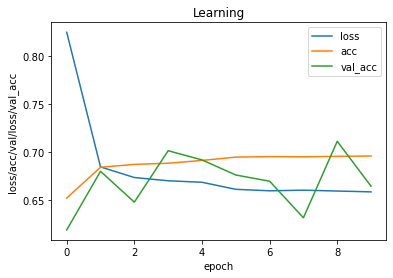

In [71]:
epoch = 10
val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy'] 
loss = history.history['loss'] 
acc = history.history['accuracy'] 
plt.xlabel('epoch')
plt.ylabel('loss/acc/val/loss/val_acc')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), acc, label = "acc") 
# plt.plot(range(epoch), val_loss, label = "val_loss")
plt.plot(range(epoch), val_acc, label = "val_acc") 
plt.legend()


In [62]:
history2 = model.fit(X_train,y_train_e,epochs=20, validation_data=(X_test,y_test_e), batch_size=128, callbacks=[checkpoint,\
                                                                                              tensorboard_callback])

Epoch 1/20
30413/30422 [============================>.] - ETA: 0s - loss: 0.6642 - accuracy: 0.6971
Epoch 1: val_accuracy did not improve from 0.71127
30422/30422 [==============================] - 96s 3ms/step - loss: 0.6642 - accuracy: 0.6971 - val_loss: 18.4843 - val_accuracy: 0.6075
Epoch 2/20
30410/30422 [============================>.] - ETA: 0s - loss: 0.5596 - accuracy: 0.7796
Epoch 2: val_accuracy did not improve from 0.71127
30422/30422 [==============================] - 95s 3ms/step - loss: 0.5596 - accuracy: 0.7796 - val_loss: 35.9778 - val_accuracy: 0.6461
Epoch 3/20
30419/30422 [============================>.] - ETA: 0s - loss: 0.5467 - accuracy: 0.7844
Epoch 3: val_accuracy did not improve from 0.71127
30422/30422 [==============================] - 96s 3ms/step - loss: 0.5467 - accuracy: 0.7844 - val_loss: 3.3055 - val_accuracy: 0.7007
Epoch 4/20
30412/30422 [============================>.] - ETA: 0s - loss: 0.2694 - accuracy: 0.9259
Epoch 4: val_accuracy did not improve

# BEST MODEL
* At epoch 13, val_accuracy: **0.76** 

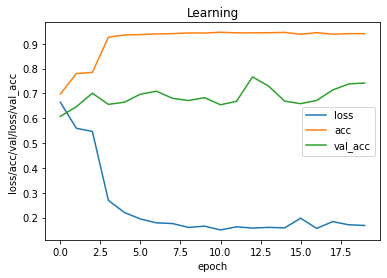

In [70]:
epoch = 20
val_loss = history2.history['val_loss']
val_acc = history2.history['val_accuracy'] 
loss = history2.history['loss'] 
acc = history2.history['accuracy'] 
plt.xlabel('epoch')
plt.ylabel('loss/acc/val/loss/val_acc')
plt.title('Learning')
plt.plot(range(epoch), loss, label = "loss")
plt.plot(range(epoch), acc, label = "acc") 
# plt.plot(range(epoch), val_loss, label = "val_loss")
plt.plot(range(epoch), val_acc, label = "val_acc") 
plt.legend()


In [86]:
%load_ext tensorboard

In [87]:
tensorboard --logdir=logs/fits  --host localhost --port 8088

In [5]:
from sklearn.preprocessing import OrdinalEncoder
test_df = pd.read_csv("test.csv")
test_df_ = test_df.drop([ 'id'], axis=1 )
exp_te = np.expand_dims(test_df_['experiment'].values, axis=1)
enc = OrdinalEncoder()
enc.fit(exp_te)
print(enc.categories_)
test_df_['experiment'] = enc.fit_transform(exp_te)  

[array(['LOFT'], dtype=object)]


In [3]:
best_model_loaded = tf.keras.models.load_model("model_save/weights-13-0.7663.hdf5", compile=False) 

## CAN'T to prediction on 4GB test data 'cause of OOM error (even 24 GB RAM not enough), same problem in Colab So,  testing in chunks!

In [6]:
print(test_df_.shape)

(17965143, 27)


## Making prediction on a chunk of size 1000000, will prevent OOM error!

In [96]:
from tqdm import tqdm
i, j, cnt = 0, 1000000, 1
stacked_pred = np.zeros((1,4))
for _ in tqdm(range(18)):
    chunk = test_df_.iloc[i:j]
    y_pred_nn = best_model_loaded.predict(chunk)
    stacked_pred = np.vstack((stacked_pred, y_pred_nn))
    i = j
    j = i + 1000000
    cnt += 1
    
    

100%|██████████████████████████████████████████████████████████████████████████████████| 18/18 [07:15<00:00, 24.21s/it]


In [101]:
sub = pd.DataFrame(np.concatenate((np.arange(len(test_df_))[:, np.newaxis], stacked_pred[1:, :]), axis=1), columns=['id', 'A', 'B', 'C', 'D'],)
sub['id'] = sub['id'].astype(int)

In [102]:
sub.to_csv('result_neural_network.csv', index=False)

![title](NN_no_fe_score.png)

# Extremely Poor results on Neural network model on Kaggle!

In [82]:
# TF_ENABLE_GPU_GARBAGE_COLLECTION=False

In [84]:
# joblib.dump(model, "model")

INFO:tensorflow:Assets written to: ram://a4df09ee-865b-458b-846e-dcec2f7dd2ef/assets


['model']

# Summary

Log loss on TRAIN Data using Random Model **1.6444425154133833**

Log loss on TEST Data using Random Model **1.64606303273689**

In [43]:
from prettytable import PrettyTable 

myTable = PrettyTable(["Model", "Approach","train logloss", "cv logloss", "Kaggle score(private)"])
  

myTable.add_row(["Logistic regression","No FE + min-max scaling", "0.915", "0.915", "10.97"])
myTable.add_row(["Decision tree","No FE + min-max scaling", "0.010", "0.0115", "10.55"])
myTable.add_row(["Random forest","No FE + min-max scaling", "0.02", "0.074", "2.245"])
myTable.add_row(["Neural network","No FE + No min-max scaling + using all columns", "0.16", "0.94", "5.26"])
myTable.add_row(["Light GBM","No FE + min-max scaling", "0.0424", "0.0425", "1.05"])
myTable.add_row(["Light GBM","No FE + No min-max scaling + using all columns", "0.135998", "0.372470", "0.53"])
print(myTable)

+---------------------+------------------------------------------------+---------------+------------+-----------------------+
|        Model        |                    Approach                    | train logloss | cv logloss | Kaggle score(private) |
+---------------------+------------------------------------------------+---------------+------------+-----------------------+
| Logistic regression |            No FE + min-max scaling             |     0.915     |   0.915    |         10.97         |
|    Decision tree    |            No FE + min-max scaling             |     0.010     |   0.0115   |         10.55         |
|    Random forest    |            No FE + min-max scaling             |      0.02     |   0.074    |         2.245         |
|    Neural network   | No FE + No min-max scaling + using all columns |      0.16     |    0.94    |          5.26         |
|      Light GBM      |            No FE + min-max scaling             |     0.0424    |   0.0425   |          1.05   

## ALL models are doing bettter than Random model